In [1]:
%run Classes/SPDEs.ipynb
%run Classes/Rule.ipynb
%run Classes/Model.ipynb
%run Classes/Noise.ipynb
%run Classes/full_visualization.ipynb
%run Algorithms/Algorithm_2_FFT.ipynb
%run Classes/Burgers_PDE_FIND.ipynb

#Disable progress bars from tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

In [2]:
# Set global parameters

a, b, s, t = 0, 16, 0, 10 # space-time boundaries

X_, T_ = np.linspace(a,b,513), np.linspace(s,t,2001) # space-time grid for generating solutions
x_space = 1
t_space = 10
X, T = X_[::x_space], T_[::t_space] # space-time grid of observed points. O_X and O_T

eps = 0.2 #Viscosity

k = 120 # Number of realizations (multiple of 3)
m = 20 # Number of test cases, m < k

N = 10 # Number of experiments

noise = 0.00 #noise intensity

#Model parameters
height = 3
deg = 5
kernel_deg = 2
noise_deg = -1.5
free_num = 2
BC = 'P'

R = Rule(kernel_deg = kernel_deg,
         noise_deg = noise_deg,
         free_num = free_num) # initialize rule. No multiplicative width and forcing. 

#Polynomial interpolation parameters for PDE-FIND
deg_x = 4
deg_t = 4

true_eps = False #whether to use true value of eps (vs. estimated value) for PDE-FIND
finite_diff = False #whether to use finite difference (vs poly interpolation) for PDE-FIND

offset_x = 20
offset_t = 20

time_scale = 10 # increase the time interval for finer Euler scheme in PDE-FIND

In [6]:
%%time

exps_Alg2 = []

for n in range(0,N):
    # Create realizations of initial conditions.
    s = -time()
    IC1 = Noise().initial(k//3, X_, scaling = 1) # one cycle
    IC2 = Noise().initial(k//3, X_, scaling = 2) # two cycles
    IC4 = Noise().initial(k//3, X_, scaling = 4) # four cycles

    IC = np.concatenate([IC1, IC2, IC4])

    W = np.zeros((k, len(T_), len(X_))) # No forcing
    
    #Generate solutions
    Burgers_ = SPDE(BC = BC, IC = IC, eps = eps).Burgers_FFT(W, T = T_, X = X_) # solve Burger's equations on the fine grid

    Burgers = Burgers_[:,::t_space,::x_space] # Observed points of Burger's equations
    
    Burgers = np.float32(Burgers)
    
    # Translate solution to a dataframe for the visualization class
    Burgers_true = [pd.DataFrame(B, index = T, columns = X) for B in Burgers]
    
    #
    test = np.random.choice(np.arange(k), m, replace = False) # choose test set
        
       
    Burgers_noise = np.array([B+np.random.normal(scale = noise*np.abs(B).mean().mean(), size = (len(T),len(X))) for B in Burgers_true])
    Burgers_noise = Burgers_noise.astype('float32')
    for i in range(k):
        Burgers_noise[i, :, -1] = Burgers_noise[i, :, 0]
    
    
    #ALGORITHM 2
    
    experiment_noise = IML(Burgers_noise,
                           Rule = R,
                           eps = eps,
                           height = height,
                           deg = deg,
                           T = T,
                           X = X,
                           step = 1) # initialize experiment for algorithm 2
    experiment_noise.set_train_test(test = test) # initialize test set

    experiment_noise.set_trees() # extract trees

    experiment_noise.training_models(time_grid_num = 10) # Create models for Step 2 of Algorithm 2
    
    
    experiment_noise.fit_training_model() # Linear fit for Step 2 of Algorithm 2
    experiment_noise.learn_with_fitted() # Recurcive steps 3 & 4 of Algorithm 2
    
    
    # Predicted values on the noisy data. Outliers that blow up during the experiment are excluded

    Prediction_noise = experiment_noise.to_df_list()
    show_prediction = summary(test)

    outliers = []
    #outliers = [i for i in range(len(test)) if show_prediction.one_error(i, Burgers_true, Prediction_noise) > 1]
    test_no_outliers = [test[i] for i in range(len(test)) if i not in outliers]
    Prediction_noise = [Prediction_noise[i] for i in range(len(test)) if i not in outliers]
    
    print('Numerical Scheme for Algorithm 2 failed for {} equation with the above coefficients.'.format(len(outliers)))
    
    # Errors
    show_no_outliers = summary(test_no_outliers)
    er = show_no_outliers.errors(Burgers_true, Prediction_noise, show = False, full = False)
    exps_Alg2.append(show_no_outliers)
    
    print("Finished Experiment {} in {} seconds".format(n+1,s+time()))


Creating Model
Numerical Scheme for Algorithm 2 failed for 0 equation with the above coefficients.
Finished Experiment 1 in 652.3277728557587 seconds
Creating Model
Numerical Scheme for Algorithm 2 failed for 0 equation with the above coefficients.
Finished Experiment 2 in 650.5461702346802 seconds
Creating Model
Numerical Scheme for Algorithm 2 failed for 0 equation with the above coefficients.
Finished Experiment 3 in 697.5191757678986 seconds
Creating Model
Numerical Scheme for Algorithm 2 failed for 0 equation with the above coefficients.
Finished Experiment 4 in 647.3715536594391 seconds
Creating Model
Numerical Scheme for Algorithm 2 failed for 0 equation with the above coefficients.
Finished Experiment 5 in 670.3766660690308 seconds
Creating Model
Numerical Scheme for Algorithm 2 failed for 0 equation with the above coefficients.
Finished Experiment 6 in 705.2861707210541 seconds
Creating Model
Numerical Scheme for Algorithm 2 failed for 0 equation with the above coefficients.
F

In [7]:
for exps in [exps_Alg2]:

    print("Average average error:", np.mean([e.av_er for e in exps]))
    print("Maximum average error:", max([e.av_er for e in exps]))
    print("Minimum average error:", min([e.av_er for e in exps]))
    print('')

    print("Average maximum error:", np.mean([e.max_er for e in exps]))
    print("Maximum maximum error:", max([e.max_er for e in exps]))
    print("Minimum maximum error:", min([e.max_er for e in exps]))
    print('')

    print("Average minimum error:", np.mean([e.min_er for e in exps]))
    print("Maximum minimum error:", max([e.min_er for e in exps]))
    print("Minimum minimum error:", min([e.min_er for e in exps]))
    print('')

    print("=====================")

Average average error: 0.0016325415947444064
Maximum average error: 0.010175780999663533
Minimum average error: 0.0002683378607781308

Average maximum error: 0.005949685671754028
Maximum maximum error: 0.03204583203806714
Minimum maximum error: 0.0006372092561327625

Average minimum error: 0.0002536555618522041
Maximum minimum error: 0.0015581386859806685
Minimum minimum error: 3.559046674598034e-05



In [8]:
for exps in [exps_Alg2]:

    print("Average std:", np.mean([e.std_er for e in exps]))
    print("Maximum std:", max([e.std_er for e in exps]))
    print("Minimum std:", min([e.std_er for e in exps]))
    print('')

    print("=====================")

Average std: 0.0015218281877733297
Maximum std: 0.008539211519163006
Minimum std: 0.00016305284200044792



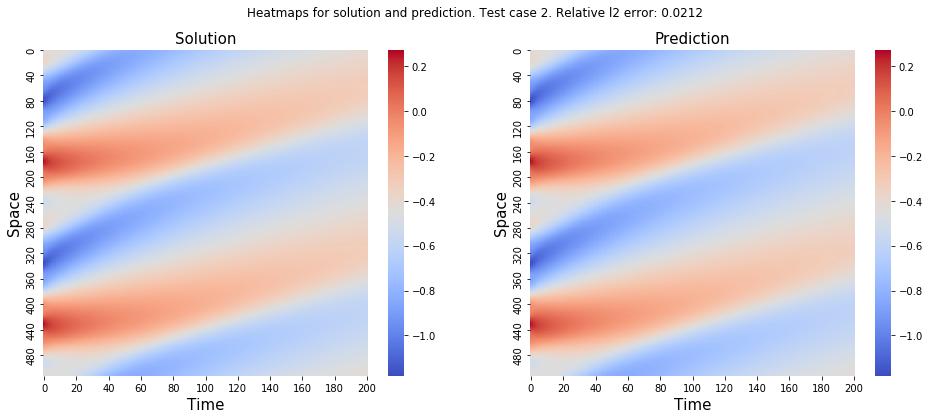

In [11]:
show_no_outliers.full_comparison(1, Burgers_true, Prediction_noise)

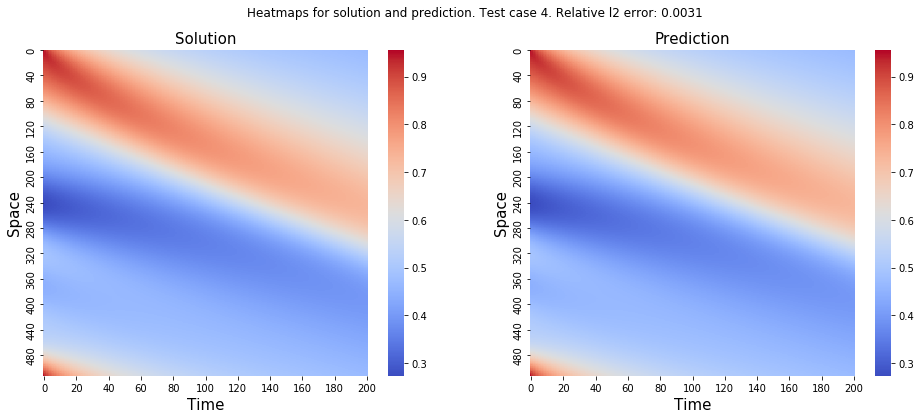

In [12]:
show_no_outliers.full_comparison(3, Burgers_true, Prediction_noise)